<h2>Two Input Networks Using Categorical Embeddings, Shared Layers, & Merge Layers
</h2>

In [ ]:
import warnings
warnings.filterwarnings( 'ignore' )

import os
import gc
import joblib
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as klyr
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option( 'display.max_rows', 8 )
pd.set_option( 'display.max_columns', None )

<br>

###  Deep Neural Network to predict:
     faults in the Steel (Classification)
     estimate concrete strength (Numerical Estimation)
<br>

### Faults in the Steel (Classification)

In [19]:
steelPlateFaults_data = os.path.join( os.getcwd(), 'datasets//steelPlatesFaults//Faults.NNA'  )
steelPlateFaults_metadata = os.path.join( os.getcwd(), 'datasets//steelPlatesFaults//Faults27x7_var'  )

with open( steelPlateFaults_metadata, 'r' ) as file1:
    steel_metaData = file1.read()
    
with open( steelPlateFaults_data, 'r' ) as file1:
    steel_data = file1.read()
    
steel_metaData

'X_Minimum\nX_Maximum\nY_Minimum\nY_Maximum\nPixels_Areas\nX_Perimeter\nY_Perimeter\nSum_of_Luminosity\nMinimum_of_Luminosity\nMaximum_of_Luminosity\nLength_of_Conveyer\nTypeOfSteel_A300\nTypeOfSteel_A400\nSteel_Plate_Thickness\nEdges_Index\nEmpty_Index\nSquare_Index\nOutside_X_Index\nEdges_X_Index\nEdges_Y_Index\nOutside_Global_Index\nLogOfAreas\nLog_X_Index\nLog_Y_Index\nOrientation_Index\nLuminosity_Index\nSigmoidOfAreas\nPastry\nZ_Scratch\nK_Scatch\nStains\nDirtiness\nBumps\nOther_Faults\n'

In [95]:
# pd.DataFrame( [steel_data )
pd.set_option('display.max_columns', 500)
steel_df = pd.read_csv(    steelPlateFaults_data, sep= '\t', names= list(  filter( None, steel_metaData.split('\n') )  )    )
print( steel_df.shape ); steel_df.head()

(1941, 34)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [82]:
col_NoNorm_ls = [ 'TypeOfSteel_A400', 'TypeOfSteel_A300', 'Outside_Global_Index', 'Pastry', 'Z_Scratch',  'K_Scatch', 'Stains', 'Dirtiness', 'Bumps' ]

colNorm_ls = [  'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
                'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
                'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
                'Steel_Plate_Thickness',
                'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 
                'LogOfAreas',
                'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
                'SigmoidOfAreas'   ]

In [97]:
scaler_obj = sklearn.preprocessing.MinMaxScaler( feature_range= (0,1) )
# df[col_ls] = 
steel_df[colNorm_ls] =  scaler_obj.fit_transform(  steel_df[colNorm_ls] )
steel_df = steel_df.rename( columns= { 'Other_Faults': 'faults' }  ) 
steel_df

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,faults
0,0.024633,0.026916,0.020352,0.020354,0.001736,0.001436,0.002369,0.002068,0.374384,0.328704,0.811287,1,0,0.153846,0.050040,0.255853,0.174952,0.003660,0.462865,1.000000,1.0,0.435312,0.217122,0.385916,0.912493,0.431200,0.525766,1,0,0,0,0,0,0
1,0.378299,0.378584,0.195006,0.195007,0.000694,0.000766,0.001598,0.000962,0.413793,0.398148,0.811287,1,0,0.153846,0.768388,0.401843,0.200262,0.002402,0.594156,0.965006,1.0,0.354804,0.172082,0.343391,0.899834,0.501706,0.203632,1,0,0,0,0,0,0
2,0.486217,0.486249,0.119190,0.119190,0.000452,0.000574,0.000992,0.000666,0.487685,0.407407,0.698413,1,0,0.230769,0.975683,0.362962,0.327720,0.002516,0.746347,0.944725,1.0,0.317509,0.172082,0.294761,0.836082,0.533882,0.108967,1,0,0,0,0,0,0
3,0.500293,0.500878,0.027938,0.027940,0.001140,0.001053,0.002424,0.001617,0.487685,0.412037,0.222222,0,1,0.961538,0.732215,0.467528,0.148533,0.004231,0.531757,1.000000,1.0,0.398243,0.196206,0.388194,0.925707,0.513163,0.456527,1,0,0,0,0,0,0
4,0.756012,0.761849,0.037853,0.037872,0.015768,0.005552,0.014269,0.021282,0.182266,0.412037,0.222222,0,1,0.557692,0.069835,0.475262,0.058385,0.012694,0.272829,0.987915,1.0,0.630962,0.335184,0.565877,0.970797,0.487325,1.000000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,0.146041,0.159743,0.024580,0.024580,0.001775,0.004978,0.001157,0.003001,0.586207,0.481481,0.234568,0,1,0.000000,0.367966,0.413815,0.567813,0.021844,0.511465,0.713430,0.0,0.437299,0.413328,0.282739,0.283654,0.610299,0.688309,0,0,0,0,0,0,1
1937,0.084457,0.100059,0.025720,0.025720,0.001867,0.004020,0.001267,0.002963,0.551724,0.444444,0.234568,0,1,0.000000,0.212822,0.482466,0.544620,0.024360,0.700284,0.693464,0.0,0.441743,0.429267,0.288938,0.272053,0.573248,0.792622,0,0,0,0,0,0,1
1938,0.085044,0.099473,0.029279,0.029279,0.001900,0.003637,0.001157,0.003220,0.591133,0.476852,0.234568,0,1,0.000000,0.214228,0.348236,0.513159,0.022644,0.720982,0.665616,0.0,0.443279,0.418809,0.276164,0.256317,0.611883,0.668445,0,0,0,0,0,0,1
1939,0.080352,0.097133,0.032030,0.032032,0.002732,0.009094,0.002534,0.004526,0.576355,0.476852,0.234568,0,1,0.000000,0.202472,0.625490,0.938893,0.026075,0.330560,0.642287,0.0,0.475393,0.439039,0.350201,0.469259,0.598294,0.990806,0,0,0,0,0,0,1


In [105]:
xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split(
                            steel_df.drop( columns= 'faults' ), steel_df[['faults']],
                            test_size= 30./100, random_state= 10  )

In [115]:
kseqModel1 = keras.Sequential(  [
    klyr.Dense(  units= 100, activation= 'relu', input_shape= ( xtrn.shape[-1],  )  ),
    klyr.Dense(  units= 50, activation= 'relu'  ),
    klyr.Dense(  25, activation= 'relu'  ),
    klyr.Dense(  12, activation= 'relu'  ),
    klyr.Dense(  6, activation= 'relu'  ),
    klyr.Dense(  4, activation= 'relu'  ),
    klyr.Dense(  1, activation= 'sigmoid'  ),
]  )

kseqModel1.compile(   optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['accuracy']   )
kseqModel1.summary()

kseqModel1_fit = kseqModel1.fit(  x= xtrn, y= ytrn, epochs= 20, validation_split= 25./100  )


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 100)               3400      
                                                                 
 dense_49 (Dense)            (None, 50)                5050      
                                                                 
 dense_50 (Dense)            (None, 25)                1275      
                                                                 
 dense_51 (Dense)            (None, 12)                312       
                                                                 
 dense_52 (Dense)            (None, 6)                 78        
                                                                 
 dense_53 (Dense)            (None, 4)                 28        
                                                                 
 dense_54 (Dense)            (None, 1)                

32/32 [==============================] - 1s 8ms/step - loss: 0.6755 - accuracy: 0.7849 - val_loss: 0.6494 - val_accuracy: 0.8059
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5901 - accuracy: 0.9018 - val_loss: 0.5172 - val_accuracy: 0.9412
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.4547 - accuracy: 0.9735 - val_loss: 0.3936 - val_accuracy: 0.9882
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.3096 - accuracy: 0.9990 - val_loss: 0.1773 - val_accuracy: 1.0000
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0659 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 7/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 8/20
32/32 [=============

In [180]:
## yhat

yhat_tst = np.squeeze (  np.round(  kseqModel1.predict( x= xtst )  )   )

conf_mtrx = sklearn.metrics.confusion_matrix( ytst, yhat_tst )
print( conf_mtrx, sklearn.metrics.precision_score( ytst, yhat_tst ), sklearn.metrics.recall_score( ytst, yhat_tst )  )

19/19 [==============================] - 0s 2ms/step
array([[380,   0],
       [  0, 203]]) 1.0 1.0


In [182]:
yhat_tst_df = pd.DataFrame(   { 'yhat':yhat_tst, 'ytst': ytst['faults'].to_numpy() }   )
yhat_tst_df['diff'] = yhat_tst_df['yhat'] -  yhat_tst_df['ytst']

print(  yhat_tst_df['diff'].value_counts(), '\n\n'  )
yhat_tst_df

0.0    583
Name: diff, dtype: int64 




,yhat,ytst,diff
0,0.0,0,0.0
1,0.0,0,0.0
2,0.0,0,0.0
3,0.0,0,0.0
4,0.0,0,0.0
...,...,...,...
578,1.0,1,0.0
579,1.0,1,0.0
580,0.0,0,0.0
581,1.0,1,0.0


<br>

### Deep Neural Network for Estimating concrete strength (Numerical Estimation)

In [222]:
concrete_df = pd.read_csv(   os.path.join( os.getcwd(), 'datasets//civilEng_concreteStrength.csv'  )   )
concrete_df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06


In [191]:
# import missingno as msno
# msno.matrix( concrete_df )
concrete_df.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

<AxesSubplot:>

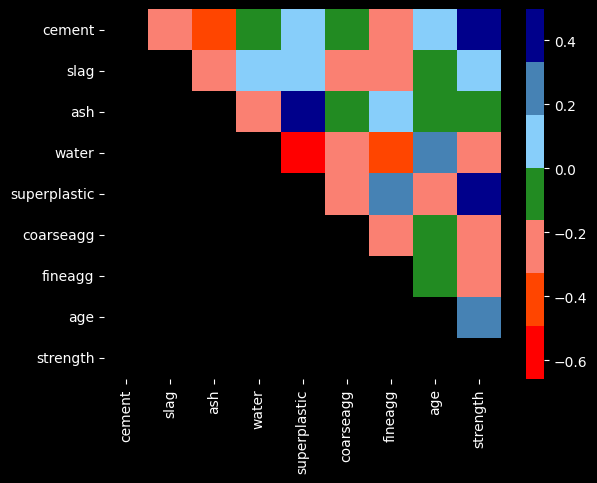

In [224]:
## correlation
color_ls = [ 'darkblue', 'darkslateblue', 'skyblue', 'salmon', 'orangered', 'red' ] 

corr_mtrx  = concrete_df.corr()
mask_center = np.tril(  np.ones_like(corr_mtrx), k=0  )

color_ls = [ 'red', 'orangered', 'salmon', 'forestgreen', 'lightskyblue', 'steelblue', 'darkblue' ]
sns.heatmap(  concrete_df.corr(), cmap= sns.color_palette( color_ls, as_cmap= True ), mask= mask_center  )

In [223]:
## standarization
col_ls = [ 'cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg','fineagg', 'age' ]

scaler_obj = sklearn.preprocessing.MinMaxScaler( feature_range= (0,1) )
# df[col_ls] = 
concrete_df[ col_ls ] = scaler_obj.fit_transform(  concrete_df[col_ls] )
# steel_df = steel_df.rename( columns= { 'Other_Faults': 'faults' }  ) 
concrete_df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,0.089726,0.589872,0.000000,0.652556,0.000000,0.496512,0.387607,0.074176,29.89
1,0.152740,0.117418,0.621189,0.291534,0.335404,0.813372,0.507275,0.035714,23.51
2,0.337900,0.000000,0.478261,0.523962,0.170807,0.453198,0.670346,0.074176,29.22
3,0.374429,0.317195,0.000000,0.848243,0.000000,0.380814,0.190667,0.074176,45.85
4,0.120548,0.510295,0.000000,0.571086,0.282609,0.716279,0.257652,0.074176,18.29
...,...,...,...,...,...,...,...,...,...
1025,0.075342,0.000000,0.829585,0.464856,0.310559,0.465116,0.529353,0.074176,13.29
1026,0.980137,0.000000,0.000000,0.159744,0.875776,0.148547,0.751882,0.005495,41.30
1027,0.398174,0.322760,0.451274,0.461661,0.276398,0.200872,0.437280,0.074176,44.28
1028,0.547945,0.105732,0.000000,0.848243,0.000000,0.380814,0.190667,0.739011,55.06


In [225]:
xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split(
                            concrete_df.drop( columns= 'strength' ), concrete_df[['strength']],
                            test_size= 30./100, random_state= 10  )

In [254]:
kseqModel1 = keras.Sequential(  [
    klyr.Dense(  500, activation= 'relu', input_shape= ( xtrn.shape[-1], ) ),
    klyr.Dense(  250, activation= 'relu'  ),
    klyr.Dense(  125, activation= 'relu'  ),
    klyr.Dense(  60, activation= 'relu'  ),
    klyr.Dense(  30, activation= 'relu'  ),
    klyr.Dense(  15, activation= 'relu'  ),
    klyr.Dense(  8, activation= 'relu'  ),
    klyr.Dense(  4, activation= 'relu'  ),
    klyr.Dense(  2, activation= 'relu'  ),
    klyr.Dense(  1  )
]  )
kseqModel1.compile(  optimizer= 'adam', loss= 'mean_squared_error', metrics= ['mean_squared_error'] )
earlyMonitor_obj = keras.callbacks.EarlyStopping(  monitor= 'mean_squared_error', min_delta= 1e-2, patience= 100,
                                                   verbose= 1, mode= 'auto', restore_best_weights= True )

kseqModel1.summary()

kseqModel1_fit = kseqModel1.fit(  x= xtrn, y= ytrn, epochs= 2000,
                                  validation_data= (xtst,ytst), callbacks= [earlyMonitor_obj]  )

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_252 (Dense)           (None, 500)               4500      
                                                                 
 dense_253 (Dense)           (None, 250)               125250    
                                                                 
 dense_254 (Dense)           (None, 125)               31375     
                                                                 
 dense_255 (Dense)           (None, 60)                7560      
                                                                 
 dense_256 (Dense)           (None, 30)                1830      
                                                                 
 dense_257 (Dense)           (None, 15)                465       
                                                                 
 dense_258 (Dense)           (None, 8)               

23/23 [==============================] - 1s 12ms/step - loss: 1587.2307 - mean_squared_error: 1587.2307 - val_loss: 1487.1237 - val_mean_squared_error: 1487.1237
Epoch 2/2000
23/23 [==============================] - 0s 7ms/step - loss: 1458.6727 - mean_squared_error: 1458.6727 - val_loss: 868.6638 - val_mean_squared_error: 868.6638
Epoch 3/2000
23/23 [==============================] - 0s 7ms/step - loss: 412.1713 - mean_squared_error: 412.1713 - val_loss: 262.4399 - val_mean_squared_error: 262.4399
Epoch 4/2000
23/23 [==============================] - 0s 8ms/step - loss: 224.1311 - mean_squared_error: 224.1311 - val_loss: 193.7671 - val_mean_squared_error: 193.7671
Epoch 5/2000
23/23 [==============================] - 0s 7ms/step - loss: 172.9237 - mean_squared_error: 172.9237 - val_loss: 177.9776 - val_mean_squared_error: 177.9776
Epoch 6/2000
23/23 [==============================] - 0s 6ms/step - loss: 145.7098 - mean_squared_error: 145.7098 - val_loss: 160.2521 - val_mean_squared_er

In [264]:
loss_df = pd.DataFrame( kseqModel1_fit.history)

<AxesSubplot:>

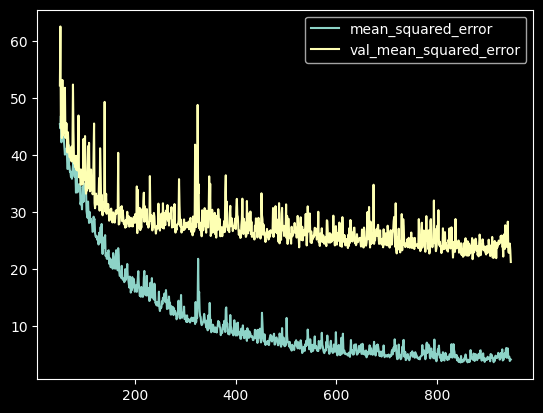

In [272]:
loss_df.loc[  50:,  [ 'mean_squared_error', 'val_mean_squared_error']  ].plot()

In [273]:
xtst

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
559,0.445662,0.000000,0.587206,0.423323,0.295031,0.644767,0.400151,0.074176
705,0.047032,0.511686,0.000000,0.652556,0.000000,0.456977,0.517060,0.016484
500,0.173516,0.361157,0.592704,0.464058,0.111801,0.599709,0.383342,0.271978
218,0.646119,0.000000,0.000000,0.512780,0.000000,0.479651,0.423984,0.005495
836,0.251142,0.000000,0.623688,0.297125,0.242236,0.826744,0.515554,0.271978
...,...,...,...,...,...,...,...,...
80,0.201598,0.000000,0.625687,0.320288,0.307453,0.834593,0.523332,0.074176
893,0.337900,0.000000,0.478261,0.559105,0.164596,0.429942,0.660311,0.271978
84,0.305936,0.000000,0.000000,0.576677,0.000000,0.485465,0.730055,0.035714
742,0.076941,0.566221,0.000000,0.510383,0.000000,0.800000,0.414701,0.074176


In [276]:
## yhat
yhat_tst = kseqModel1.predict( x= xtst )
yhat_tst.shape

10/10 [==============================] - 0s 2ms/step


(309, 1)

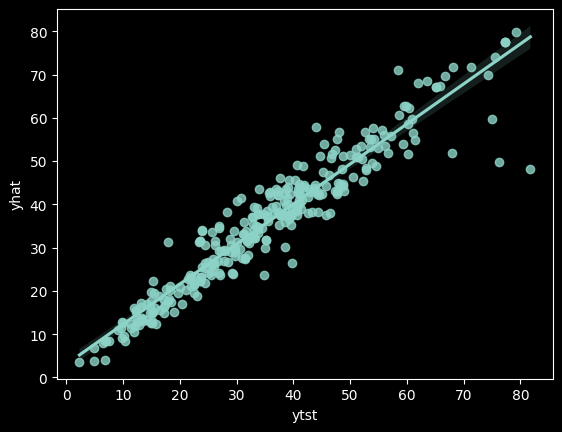

In [312]:
yhat_tst_df = pd.DataFrame(   { 'yhat':yhat_tst.reshape(-1), 'ytst': ytst['strength'].to_numpy().reshape(-1) }   )
sns.regplot( x= 'ytst', y= 'yhat', data= yhat_tst_df  )
plt.show()

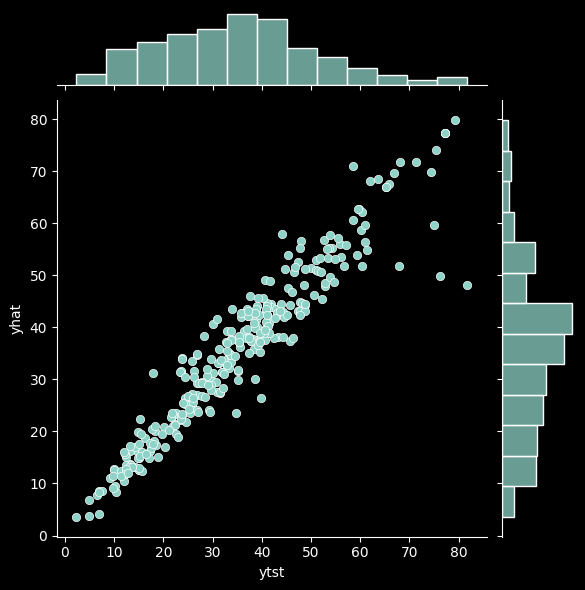

In [315]:
sns.jointplot( x= "ytst", y= "yhat", data= yhat_tst_df  )
plt.show()

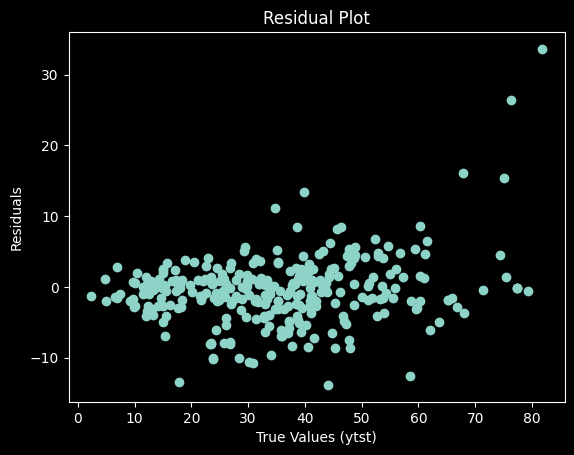

In [314]:
## residual plot
residuals = yhat_tst_df['ytst'] - yhat_tst_df['yhat']
plt.scatter(yhat_tst_df['ytst'], residuals)
plt.xlabel("True Values (ytst)"); plt.ylabel("Residuals"); plt.title("Residual Plot")
plt.show()